使用如下的线性函数生成数据：$$ y = 0.05 + \sum_{i=1}^p 0.01x_i + noise$$

这里噪音服从均值0和标准差为0.01的正态分布

In [1]:
# 设置生成过拟合的数据集（训练集20，测试集100）
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon
import mxnet as mx

num_train = 20
num_test = 100
num_inputs = 200

In [2]:
#定义模型
true_w = nd.ones((num_inputs, 1)) * 0.01
true_b = 0.05

In [3]:
#生成数据集
X = nd.random.normal(shape=(num_train + num_test, num_inputs))
y = nd.dot(X, true_w) + true_b
y += .01 * nd.random.normal(shape=y.shape)

X_train, X_test = X[:num_train, :], X[num_train, :]
y_train, y_test = y[:num_train], y[num_train:]

In [4]:
import random

batch_size = 1
def data_iter(num_examples):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i:min(i+batch_size, num_examples)])
        yield X.take(j), y.take(j)

In [5]:
#初始化模型参数
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=1,)
    params = [w, b]
    for param in params:
        param.attach_grad()
    return params

L2范数正则化

$$loss + \lambda \sum_{p \in params} ||p||_2^2$$

L2范数正则化试图惩罚绝对值较大的参数值。

In [6]:
def L2_penalty(w, b):
    return ((w**2).sum() + b**2) / 2

In [7]:
#开始测试训练
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

def net(X, w, b):
    return nd.dot(X, w) + b

def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

def test(net, params, X, y):
    return square_loss(net(X, *params), y).mean().asscalar()
    #return np.mean(square_loss(net(X, *params), y).asnumpy())

def train(lambd):
    epochs = 10
    learning_rate = 0.005
    w, b = params = init_params()
    train_loss = []
    test_loss = []
    for e in range(epochs):
        for data, label in data_iter(num_train):
            with autograd.record():
                output = net(data, *params)
                loss = square_loss(
                    output, label) + lambd * L2_penalty(*params)
            loss.backward()
            sgd(params, learning_rate, batch_size)
        train_loss.append(test(net, params, X_train, y_train))
        test_loss.append(test(net, params, X_test, y_test))
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train', 'test'])
    plt.show()
    return 'learned w[:10]:', w[:10].T, 'learned b:', b

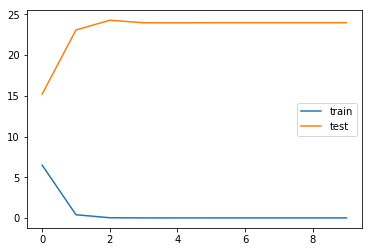

('learned w[:10]:', 
 [[ 0.30372155 -0.08122668  0.64695042 -1.51697004  0.16486931  0.42007548
    0.41177467  0.83336055 -0.66503978  3.56331921]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [ 0.12570444]
 <NDArray 1 @cpu(0)>)

In [8]:
train(0)

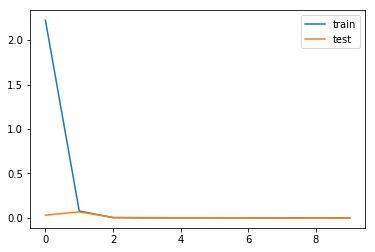

('learned w[:10]:', 
 [[ 0.01251308  0.00316699 -0.01062226  0.00017154 -0.0060801   0.00828976
    0.01331036 -0.00738668  0.00452525 -0.00868594]]
 <NDArray 1x10 @cpu(0)>, 'learned b:', 
 [ 0.00519133]
 <NDArray 1 @cpu(0)>)

In [9]:
train(5)